This notebook is supplementary material for the paper "A simple Condorcet voting method for Final Four elections" by Wesley H. Holliday (wesholliday@berkeley.edu).

It contains code to generate (1) the percentages in Figure 1, (2) the percentages in Table 1, (3) violations of independence of clones by IRV under the weak notion of clones claimed in Footnote 21, and (4) the estimated frequency of heavy top cycles referenced in Footnote 22.

In [28]:
#!pip3 install pref_voting

import pref_voting

from pref_voting.profiles import *
from pref_voting.voting_methods import *
from pref_voting.combined_methods import *
from pref_voting.margin_based_methods import *

from pref_voting.generate_profiles import generate_profile, generate_truncated_profile
from pref_voting.generate_spatial_profiles import *
from pref_voting.utility_profiles import *
from pref_voting.generate_weighted_majority_graphs import generate_edge_ordered_tournament_infinite_limit

from tqdm.notebook import tqdm

import pandas as pd
from pathos.multiprocessing import ProcessingPool as Pool

In [ ]:

for num_cands in range(3, 11):
    print("Num cands:", num_cands)
    for num_voters in range(4,20):
        print("Num voters:", num_voters)
        for n in tqdm(range(100_000)):
            prof = generate_profile(4,6)
            us = uc_bordes(prof)
            bus = beta_uncovered_set(prof)

            if us != bus:
                prof.display_margin_graph()
                print(prof)
                print(us)
                print(bus)
                break

Num cands: 3
Num voters: 4


  0%|          | 0/100000 [00:00<?, ?it/s]

In [3]:
print(pref_voting.__version__)

1.14.18


# 1. Figure 1 percentages

First we create networkx digraphs for the four tournament isomorphism types.

Linear order:


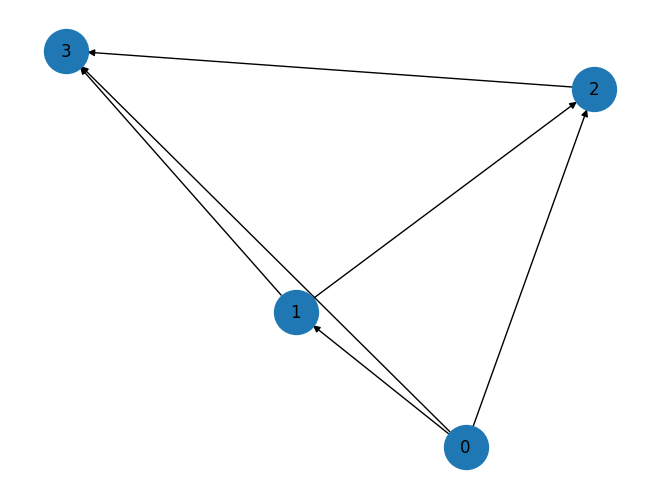

In [4]:
linear_order = nx.DiGraph()
linear_order.add_nodes_from(range(4))
linear_order.add_edges_from([(0,1),(0,2), (0,3), (1,2), (1,3), (2,3)]) 

print("Linear order:")
pos = nx.spring_layout(linear_order)
nx.draw(linear_order, pos, with_labels=True, node_size=1000)

Bottom cycle:


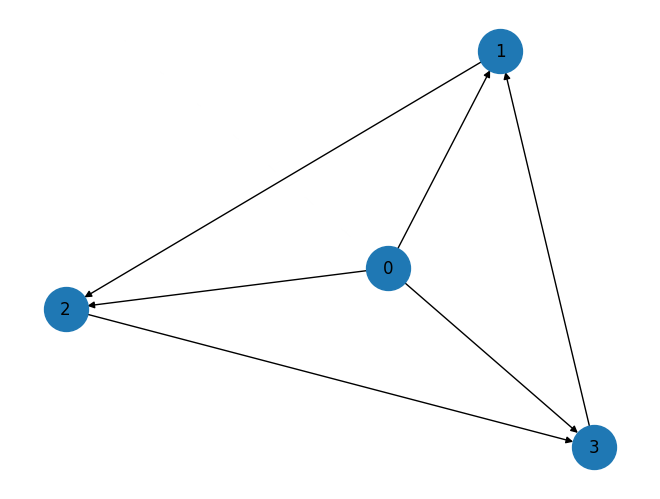

In [5]:
bottom_cycle = nx.DiGraph()
bottom_cycle.add_nodes_from(range(4))
bottom_cycle.add_edges_from([(0,1),(0,2), (0,3), (1,2), (2,3), (3,1)])

print("Bottom cycle:")
pos = nx.spring_layout(bottom_cycle)
nx.draw(bottom_cycle, pos, with_labels=True, node_size=1000)

Top cycle:


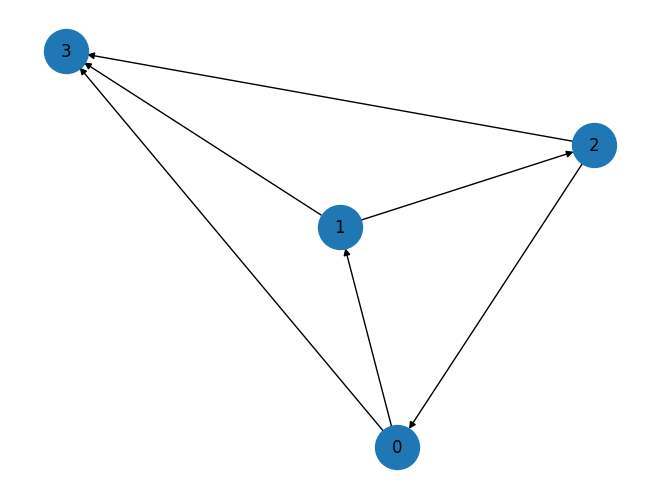

In [6]:
top_cycle = nx.DiGraph()
top_cycle.add_nodes_from(range(4))
top_cycle.add_edges_from([(0,1),(1,2), (2,0), (0,3), (1,3), (2,3)])

print("Top cycle:")
pos = nx.spring_layout(top_cycle)
nx.draw(top_cycle, pos, with_labels=True, node_size=1000)

Four cycle:


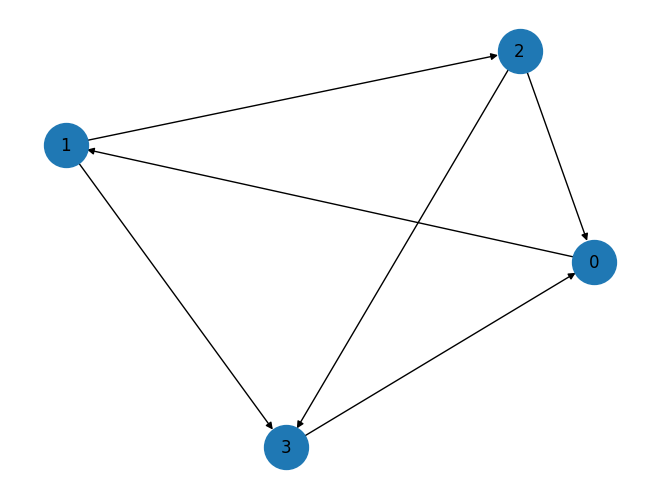

In [7]:
four_cycle = nx.DiGraph()
four_cycle.add_nodes_from(range(4))
four_cycle.add_edges_from([(0,1),(1,2), (2,3), (3,0), (2,0), (1,3)])

print("Four cycle:")
pos = nx.spring_layout(four_cycle)
nx.draw(four_cycle, pos, with_labels=True, node_size=1000)

In [8]:
from pref_voting.utility_functions import *

In [9]:
num_trials = 10_000

dict_for_df = {"num_voters": [], "num_dims": [], "utility function": [], "linear_order": [], "bottom_cycle": [], "top_cycle": [], "four_cycle": [], "num_trials": []}

for num_voters in [11, 101, 1001]:
    for num_dims in [2,4,8]:
        for util_fn in [linear_utility, quadratic_utility, shepsle_utility, matthews_utility, rm_utility, mixed_rm_utility]:

            linear_order_count = 0
            top_cycle_count = 0
            bottom_cycle_count = 0
            four_cycle_count = 0

            for n in tqdm(range(num_trials)):

                sp = generate_spatial_profile(num_cands = 4, num_voters = num_voters, num_dims = num_dims)

                up = sp.to_utility_profile(utility_function=util_fn)

                prof = up.to_ranking_profile()

                mg = prof.margin_graph()

                # Extract the underlying directed graph from mg
                g = nx.DiGraph()
                g.add_nodes_from(range(4))
                directed_edges = [(a,b) for (a,b,c) in mg.edges]
                g.add_edges_from(directed_edges)

                # Find the appropriate isomorphism type
                if nx.is_isomorphic(g, linear_order):
                    linear_order_count += 1

                if nx.is_isomorphic(g, bottom_cycle):
                    bottom_cycle_count += 1

                if nx.is_isomorphic(g, top_cycle):
                    top_cycle_count += 1

                if nx.is_isomorphic(g, four_cycle):
                    four_cycle_count += 1
                    
            print("Number of voters:", num_voters)
            print("Number of dimensions:", num_dims)
            print("Utility function:", util_fn.__name__)
            print("Linear order:", (linear_order_count / num_trials) * 100, "%")
            print("Bottom cycle:", (bottom_cycle_count / num_trials) * 100, "%")
            print("Top cycle:", (top_cycle_count / num_trials) * 100, "%")
            print("Four cycle:", (four_cycle_count / num_trials) * 100, "%")

            dict_for_df["num_voters"].append(num_voters)
            dict_for_df["num_dims"].append(num_dims)
            dict_for_df["utility function"].append(util_fn.__name__)
            dict_for_df["linear_order"].append((linear_order_count / num_trials) * 100)
            dict_for_df["bottom_cycle"].append((bottom_cycle_count / num_trials) * 100)
            dict_for_df["top_cycle"].append((top_cycle_count / num_trials) * 100)
            dict_for_df["four_cycle"].append((four_cycle_count / num_trials) * 100)
            dict_for_df["num_trials"].append(num_trials)

df = pd.DataFrame(dict_for_df)


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
def record_majority_graph_data(num_voters, num_dims, util_fn, t):
        sp = generate_spatial_profile(num_cands=4, num_voters=num_voters, num_dims=num_dims)
        up = sp.to_utility_profile(utility_function=util_fn)
        prof = up.to_ranking_profile()
        mg = prof.margin_graph()

        g = nx.DiGraph()
        g.add_nodes_from(range(4))
        directed_edges = [(a,b) for (a,b,c) in mg.edges]
        g.add_edges_from(directed_edges)

        return {
            "linear_order": int(nx.is_isomorphic(g, linear_order)),
            "bottom_cycle": int(nx.is_isomorphic(g, bottom_cycle)),
            "top_cycle": int(nx.is_isomorphic(g, top_cycle)),
            "four_cycle": int(nx.is_isomorphic(g, four_cycle))
        }

In [10]:
def majority_graph_data(
    utility_functions=[linear_utility, quadratic_utility, shepsle_utility, 
                      matthews_utility, rm_utility, mixed_rm_utility],
    numbers_of_voters=[11, 101, 1001],
    numbers_of_dims=[2, 4, 8],
    num_trials=10_000,
    use_parallel=True,
    num_cpus=4
):
    if use_parallel:
        pool = Pool(num_cpus)

    dict_for_df = {
        "num_voters": [], "num_dims": [], "utility function": [],
        "linear_order": [], "bottom_cycle": [], "top_cycle": [],
        "four_cycle": [], "num_trials": []
    }

    for num_voters in numbers_of_voters:
        for num_dims in numbers_of_dims:
            for util_fn in utility_functions:
                print(f"Voters: {num_voters}, Dimensions: {num_dims}, Utility: {util_fn.__name__}")
                
                get_data = partial(
                    record_majority_graph_data,
                    num_voters,
                    num_dims,
                    util_fn
                )

                if use_parallel:
                    data = pool.map(get_data, range(num_trials))
                else:
                    data = list(map(get_data, range(num_trials)))

                counts = {
                    key: sum(d[key] for d in data)
                    for key in ['linear_order', 'bottom_cycle', 'top_cycle', 'four_cycle']
                }

                dict_for_df["num_voters"].append(num_voters)
                dict_for_df["num_dims"].append(num_dims)
                dict_for_df["utility function"].append(util_fn.__name__)
                dict_for_df["linear_order"].append((counts['linear_order'] / num_trials) * 100)
                dict_for_df["bottom_cycle"].append((counts['bottom_cycle'] / num_trials) * 100)
                dict_for_df["top_cycle"].append((counts['top_cycle'] / num_trials) * 100)
                dict_for_df["four_cycle"].append((counts['four_cycle'] / num_trials) * 100)
                dict_for_df["num_trials"].append(num_trials)
        
    return pd.DataFrame(dict_for_df)

df = majority_graph_data(num_trials=10, use_parallel=True)

Voters: 11, Dimensions: 2, Utility: linear_utility
Voters: 11, Dimensions: 2, Utility: quadratic_utility
Voters: 11, Dimensions: 2, Utility: shepsle_utility
Voters: 11, Dimensions: 2, Utility: matthews_utility
Voters: 11, Dimensions: 2, Utility: rm_utility
Voters: 11, Dimensions: 2, Utility: mixed_rm_utility
Voters: 11, Dimensions: 4, Utility: linear_utility
Voters: 11, Dimensions: 4, Utility: quadratic_utility
Voters: 11, Dimensions: 4, Utility: shepsle_utility
Voters: 11, Dimensions: 4, Utility: matthews_utility
Voters: 11, Dimensions: 4, Utility: rm_utility
Voters: 11, Dimensions: 4, Utility: mixed_rm_utility
Voters: 11, Dimensions: 8, Utility: linear_utility
Voters: 11, Dimensions: 8, Utility: quadratic_utility
Voters: 11, Dimensions: 8, Utility: shepsle_utility
Voters: 11, Dimensions: 8, Utility: matthews_utility
Voters: 11, Dimensions: 8, Utility: rm_utility
Voters: 11, Dimensions: 8, Utility: mixed_rm_utility
Voters: 101, Dimensions: 2, Utility: linear_utility
Voters: 101, Dimen

In [11]:
df

,num_voters,num_dims,utility function,linear_order,bottom_cycle,top_cycle,four_cycle,num_trials
0,11,2,linear_utility,100.0,0.0,0.0,0.0,10
1,11,2,quadratic_utility,100.0,0.0,0.0,0.0,10
2,11,2,shepsle_utility,100.0,0.0,0.0,0.0,10
3,11,2,matthews_utility,90.0,0.0,0.0,10.0,10
4,11,2,rm_utility,80.0,0.0,0.0,20.0,10
5,11,2,mixed_rm_utility,90.0,0.0,0.0,10.0,10
6,11,4,linear_utility,90.0,10.0,0.0,0.0,10
7,11,4,quadratic_utility,90.0,10.0,0.0,0.0,10
8,11,4,shepsle_utility,80.0,0.0,20.0,0.0,10
9,11,4,matthews_utility,90.0,0.0,0.0,10.0,10


In [16]:
def construct_X(P):
    # P is a dictionary with keys as elements of the poset
    # P[x] = set of all elements under x (including x itself)

    elements = list(P.keys())
    
    # Elements of X: (a,b) where a is NOT under b in P, i.e. a ∉ P[b]
    X_elements = [(a, b) for a in elements for b in elements if a not in P[b]]
    
    X = {}
    for (c, d) in X_elements:
        # (a,b) ≤_X (c,d) iff a ≤ c in P and d ≤ b in P
        # This translates to a ∈ P[c] and d ∈ P[b].
        under_set = {(a, b) for (a, b) in X_elements if (a in P[c]) and (d in P[b])}
        X[(c, d)] = under_set
    
    return X



# Example usage:
if __name__ == "__main__":
    # Example: A simple chain: 1 < 2 < 3
    # P[x] = {y : y ≤ x}
    P = {
        1: {1, "a", "b", "c", 0},
        "c": {"a", "b", "c", 0},
        "a": {"a", 0},
        "b": {"b", 0},
        0: {0},
    }
    
    X = construct_X(P)
    for x in X:
        print(f"{x}: {X[x]}")


(1, 'c'): {(1, 'c')}
(1, 'a'): {('b', 'a'), ('c', 'a'), (1, 'a'), (1, 'c')}
(1, 'b'): {('c', 'b'), (1, 'b'), (1, 'c'), ('a', 'b')}
(1, 0): {('a', 0), ('b', 'a'), ('c', 'b'), (1, 'a'), ('c', 0), ('a', 'b'), ('c', 'a'), (1, 'c'), ('b', 0), (1, 0), (1, 'b')}
('c', 'a'): {('b', 'a'), ('c', 'a')}
('c', 'b'): {('c', 'b'), ('a', 'b')}
('c', 0): {('a', 0), ('b', 'a'), ('c', 'b'), ('a', 'b'), ('c', 0), ('c', 'a'), ('b', 0)}
('a', 'b'): {('a', 'b')}
('a', 0): {('a', 0), ('a', 'b')}
('b', 'a'): {('b', 'a')}
('b', 0): {('b', 'a'), ('b', 0)}


In [ ]:
def reg_down(P, x):
    """
    Given a poset P (a dictionary where P[a] is the set of elements under a),
    and an element x in P, return the list of all elements y such that:
    For every y' ≤ y, there exists y'' ≤ y' with y'' ≤ x.
    Equivalently, for every y' in P[y], P[x] ∩ P[y'] is nonempty.
    """
    result = []
    for y in P:
        # Check the condition: For all y' in P[y], P[x] ∩ P[y'] ≠ ∅
        # i.e. there must be some element common to both P[x] and P[y']
        if all(P[x].intersection(P[y_prime]) for y_prime in P[y]):
            result.append(y)
    return result

In [18]:
reg_down(X, ('a', 0))

[('c', 'b'), ('a', 'b'), ('a', 0)]